# Car Evaluation Classification #

**Car Evaluation Dataset**: https://archive.ics.uci.edu/dataset/19/car+evaluation

**Goal**: Determine the acceptability of a car's price given 6 features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

## Step 1: Import and Adjust Dataset ##

In [2]:
#Manually adding headers to the data
headers = ["Buying Price", "Maintanence", "#Doors", "#Persons", "Trunk Size", "Safety", "Acceptability"]

data = pd.read_csv('car.data.csv', header = None, names = headers)

#Preview the data
data.head()

,Buying Price,Maintanence,#Doors,#Persons,Trunk Size,Safety,Acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [3]:
#Assess datatypes in the dataset - all strings!
print(data.dtypes)

#Check for any NaN values in the dataset - no NaNs!
data[data.isnull().any(axis=1)]

Buying Price     object
Maintanence      object
#Doors           object
#Persons         object
Trunk Size       object
Safety           object
Acceptability    object
dtype: object


,Buying Price,Maintanence,#Doors,#Persons,Trunk Size,Safety,Acceptability


In [4]:
#Use the label encoder function of SKlearn to do convert categorical data
#via ordinal encoding

lb_Make = LabelEncoder()
data["Buying Price"] = lb_Make.fit_transform(data["Buying Price"])
data["Maintanence"] = lb_Make.fit_transform(data["Maintanence"])
data["#Doors"] = lb_Make.fit_transform(data["#Doors"])
data["#Persons"] = lb_Make.fit_transform(data["#Persons"])
data["Trunk Size"] = lb_Make.fit_transform(data["Trunk Size"])
data["Safety"] = lb_Make.fit_transform(data["Safety"])
data["Acceptability"] = lb_Make.fit_transform(data["Acceptability"])
data.head()

,Buying Price,Maintanence,#Doors,#Persons,Trunk Size,Safety,Acceptability
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [5]:
#Convert dataset to Numpy array
data = data.values

#We want a binary classification problem, so we need to relabel the last 
#column as acceptable (1) or unacceptable (0)
data[data[:,6] == 0,6] = 1
data[data[:,6] == 1,6] = 1
data[data[:,6] == 3,6] = 1
data[data[:,6] == 2,6] = 0

#Preview the data
print(data[0:5,:])

[[3 3 0 0 2 1 0]
 [3 3 0 0 2 2 0]
 [3 3 0 0 2 0 0]
 [3 3 0 0 1 1 0]
 [3 3 0 0 1 2 0]]


## Step 2: Defining Classifiers ##

In [14]:
global count 
count = 0
def draw_heatmap(acc, acc_desc, C_list, character):
    global count
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=C_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("Accuracy")
    ax.set(ylabel='$'  + character + '$')
    plt.title(acc_desc + ' w.r.t $' + character + '$')
    sns.set_style("whitegrid", {'axes.grid' : False})
    #plt.savefig('./Results/carEvaluation/' + str(count) + '.jpg', bbox_inches = 'tight')
    plt.show()
    count+=1

In [21]:
#Decision Tree (DT) Classifier
def decision_tree(X_train_val, Y_train_val, X_test, Y_test):
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    
    #Finding the optimal model
    classifier_grid = GridSearchCV(DecisionTreeClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    
    #Fit classifier with training data
    classifier_grid.fit(X_train_val, Y_train_val)
    
    #Training + validation accuracy
    DT_train_acc = classifier_grid.cv_results_['mean_train_score']
    DT_val_acc = classifier_grid.cv_results_['mean_test_score']

    #Train + test model with best parameter
    D_best_param = classifier_grid.best_params_['max_depth']
    classifier_test = DecisionTreeClassifier(max_depth=D_best_param, criterion="entropy")
    classifier_test.fit(X_train_val, Y_train_val)
    
    for i,j in enumerate(D_list):
        if j == D_best_param:
            DT_best_train_acc = DT_train_acc[i]
    
    #Test accuracy
    DT_test_acc = classifier_test.score(X_test,Y_test)
            
    #Training + validation accuracy heatmaps
    draw_heatmap(DT_train_acc.reshape(5,1), 'DT train accuracy', D_list, 'D')
    draw_heatmap(DT_val_acc.reshape(5,1), 'DT val accuracy', D_list, 'D')
    
    return DT_test_acc, DT_best_train_acc, D_best_param

In [22]:
#KNN Classifier
def knn_classifier(X_train_val, Y_train_val, X_test, Y_test):
    K_list = np.array([1, 2, 3, 4, 5, 6])
    parameters = {'n_neighbors':K_list}
    
    #Finding the optimal model
    classifier_grid = GridSearchCV(KNeighborsClassifier(), parameters, cv=5, return_train_score=True)
    
    #Fit classifier with training data
    classifier_grid.fit(X_train_val, Y_train_val)
    
    #Training + validation accuracy
    KNN_train_acc = classifier_grid.cv_results_['mean_train_score']
    KNN_val_acc = classifier_grid.cv_results_['mean_test_score']

    #Train + test model with best parameter
    K_best_param = classifier_grid.best_params_['n_neighbors']
    classifier_test2 = KNeighborsClassifier(n_neighbors=K_best_param)
    classifier_test2.fit(X_train_val,Y_train_val)
    
    for i,j in enumerate(K_list):
        if j == K_best_param:
            KNN_best_train_acc = KNN_train_acc[i]
    
    #Test accuracy
    KNN_test_acc = classifier_test2.score(X_test,Y_test)
    
    #Training + validation accuracy heatmaps
    draw_heatmap(KNN_train_acc.reshape(6,1), 'KNN train accuracy', K_list, 'K')
    draw_heatmap(KNN_val_acc.reshape(6,1), 'KNN val accuracy', K_list, 'K')
    
    return KNN_test_acc, KNN_best_train_acc, K_best_param

In [26]:
#Random Forest Classifier
def random_forest(X_train_val, Y_train_val, X_test, Y_test):
    D_list = np.array([1, 2, 3, 4, 5])
    parameters = {'max_depth':D_list}
    
    #Finding the optimal model
    classifier_grid = GridSearchCV(RandomForestClassifier(criterion="entropy"), parameters, cv=5, return_train_score=True)
    
    #Fit classifier with training data
    classifier_grid.fit(X_train_val, Y_train_val)
    
    #Training + validation accuracy
    RF_train_acc = classifier_grid.cv_results_['mean_train_score']
    RF_val_acc = classifier_grid.cv_results_['mean_test_score']

    #Train + test model with best parameter
    D_best_param = classifier_grid.best_params_['max_depth']
    classifier_test1 = RandomForestClassifier(max_depth=D_best_param, criterion="entropy")
    classifier_test1.fit(X_train_val, Y_train_val)
    
    for i,j in enumerate(D_list):
        if j == D_best_param:
            RF_best_train_acc = RF_train_acc[i]
    
    #Test accuracy
    RF_test_acc = classifier_test1.score(X_test,Y_test)
    
    #Training + validation accuracy heatmaps
    draw_heatmap(RF_train_acc.reshape(5,1), 'RF train accuracy', D_list, 'K')
    draw_heatmap(RF_val_acc.reshape(5,1), 'RF val accuracy', D_list, 'K')
    
    return RF_test_acc, RF_best_train_acc, D_best_param

In [31]:
#SVM Linear Classification
def svm_linear(X_train_val, Y_train_val, X_test, Y_test):
    classifier = svm.SVC(kernel = 'linear')
    C_list = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1]
    parameters = {'C': C_list}
    
    #Finding the optimal model
    clf = GridSearchCV(classifier, parameters, return_train_score=True, cv=5)
    
    #Fit classifier with training data
    clf.fit(X_train_val, Y_train_val)
    
    #Training + validation accuracy
    SVM_train_acc = clf.cv_results_['mean_train_score']
    SVM_val_acc = clf.cv_results_['mean_test_score']

    #Find the optimal C parameter 
    C_best_param = clf.best_params_['C']
    optimal_classifier = svm.SVC(kernel = 'linear', C=C_best_param)
    SVM_best_train_acc = None
    
    for i,j in enumerate(C_list):
        if j == C_best_param:
            SVM_best_train_acc = SVM_train_acc[i]
            break
            
    #Redefining the optimal classifier
    optimal_classifier.fit(X_train_val, Y_train_val)
    
    #Test accuracy
    SVM_test_acc = optimal_classifier.score(X_test, Y_test)

    #Training + validation accuracy heatmaps
    draw_heatmap(SVM_train_acc.reshape(-1,1), 'SVM Linear train accuracy', C_list, 'C')
    draw_heatmap(SVM_val_acc.reshape(-1,1), 'SVM Linear val accuracy', C_list, 'C')

    return SVM_test_acc, SVM_best_train_acc, C_best_param

## Step 3: Perform Classification ##

Partition:  0.2
(345, 6) (1383, 6) (345,) (1383,)


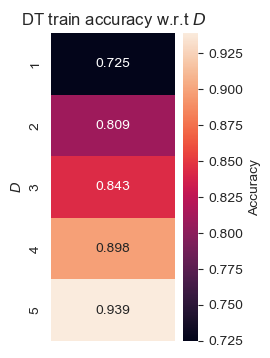

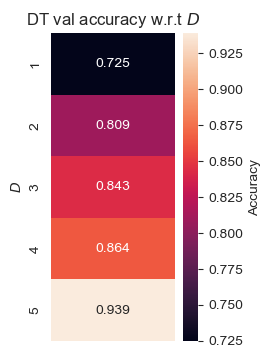

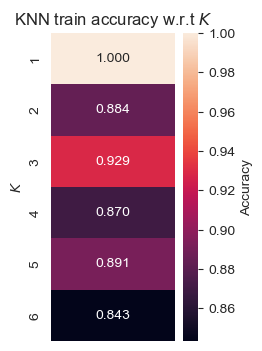

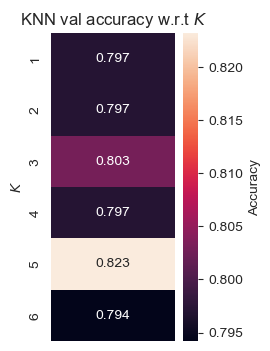

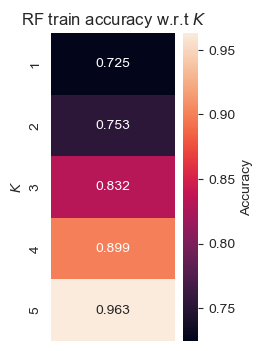

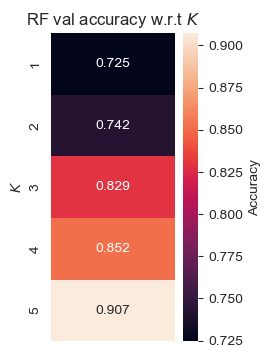

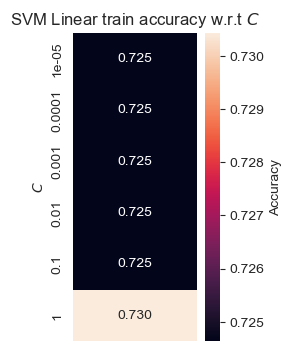

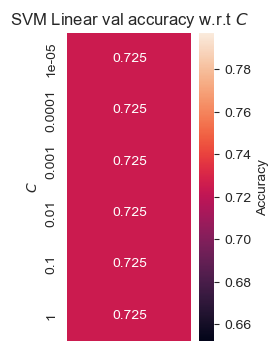

Trial # =  1
(345, 6) (1383, 6) (345,) (1383,)


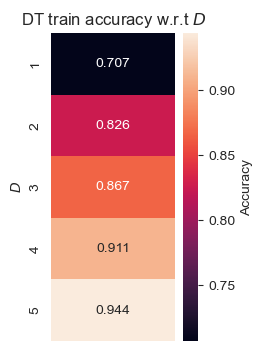

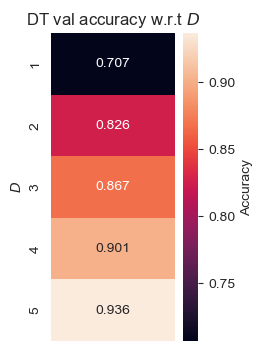

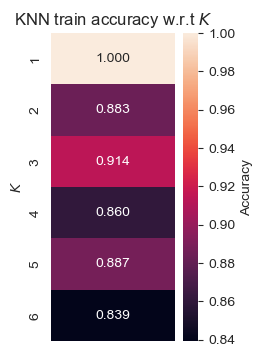

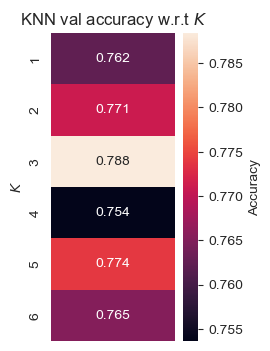

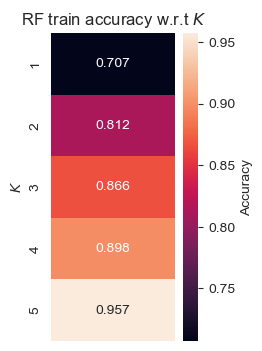

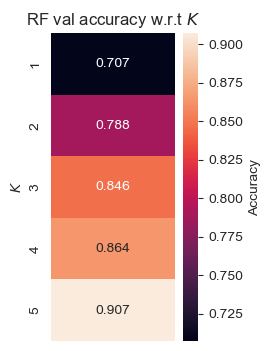

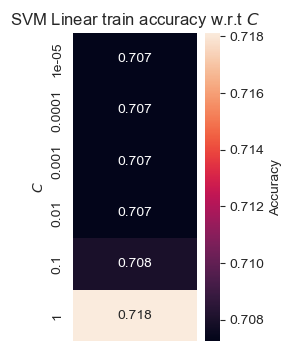

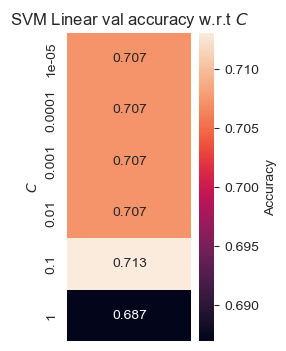

Trial # =  2
(345, 6) (1383, 6) (345,) (1383,)


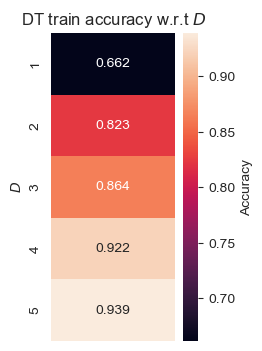

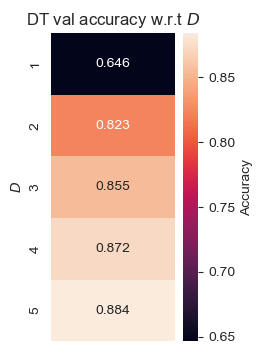

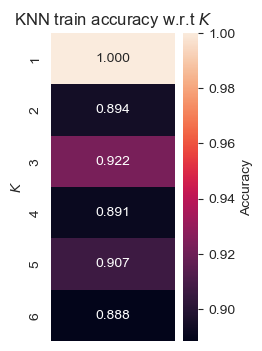

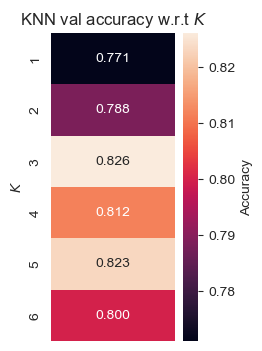

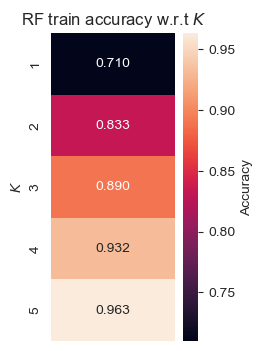

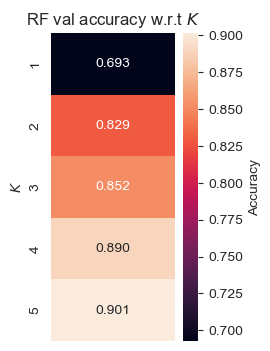

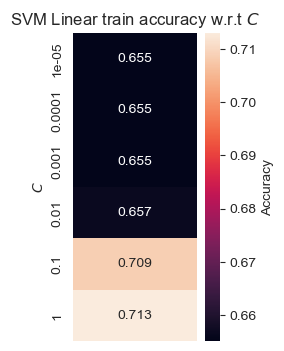

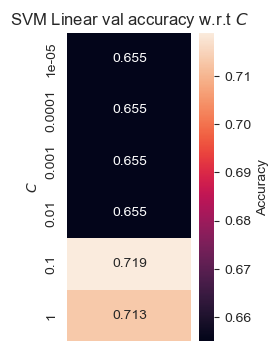

Trial # =  3
Avg Test Accuracy for Decision Tree (DT) =  0.9361291877560859
Avg Test Accuracy for KNN =  0.8435767654856591
Avg Test Accuracy for Random Forest =  0.9180525427813931
Avg Test Accuracy for SVM Linear =  0.7033020004820439
Partition:  0.5
(864, 6) (864, 6) (864,) (864,)


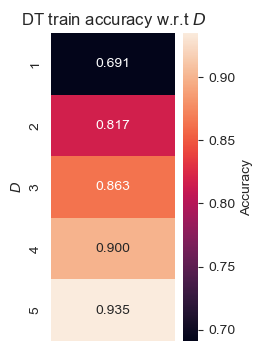

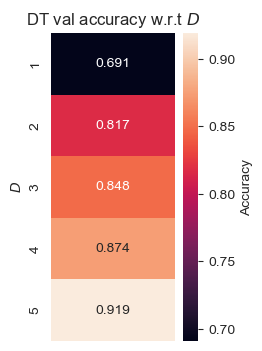

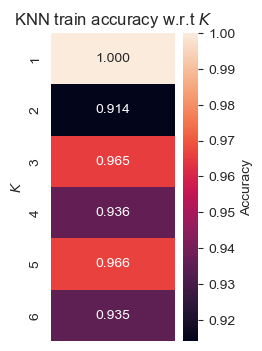

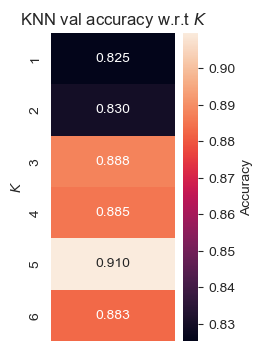

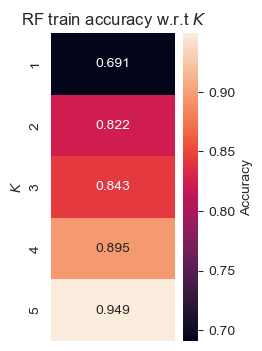

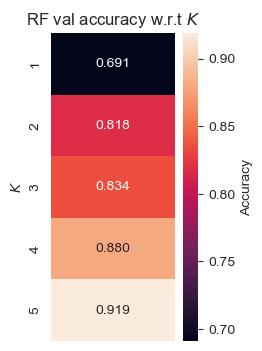

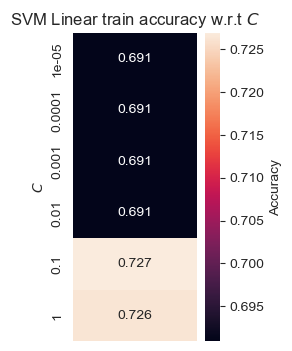

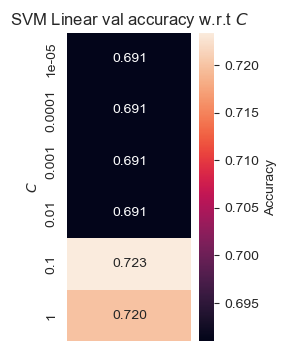

Trial # =  1
(864, 6) (864, 6) (864,) (864,)


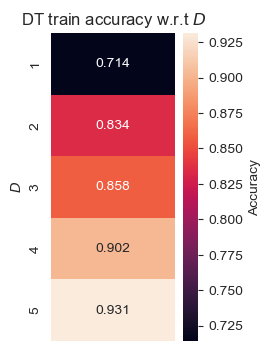

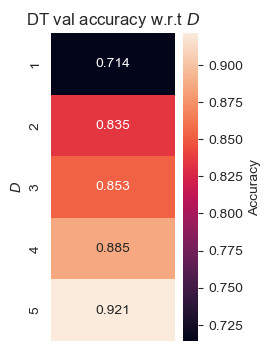

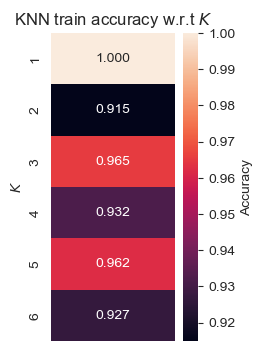

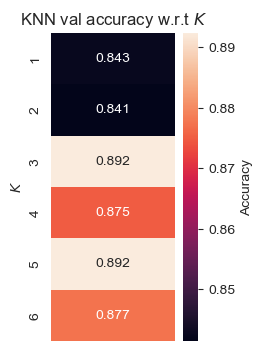

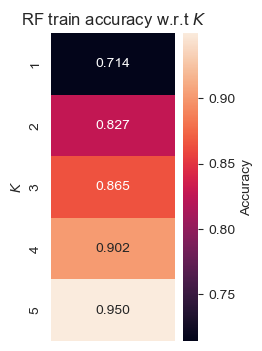

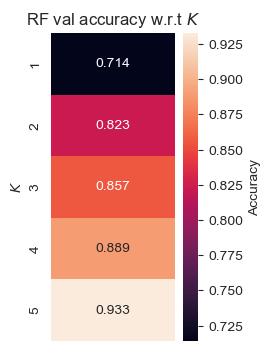

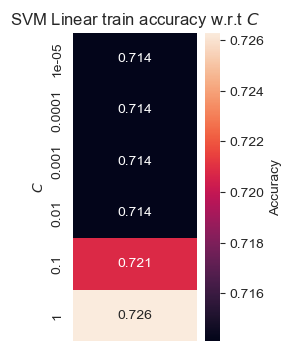

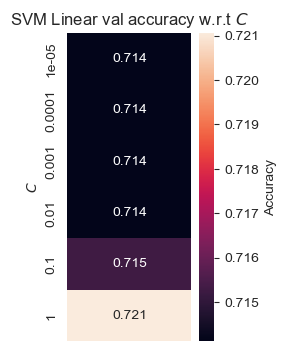

Trial # =  2
(864, 6) (864, 6) (864,) (864,)


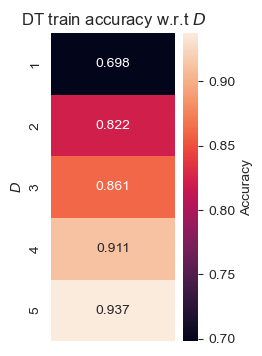

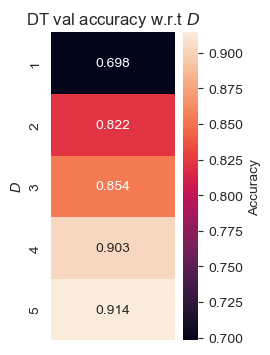

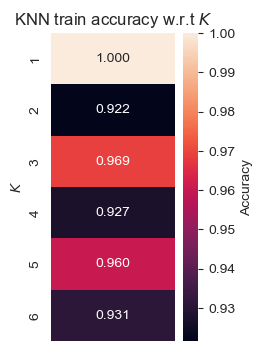

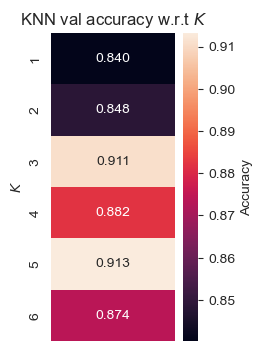

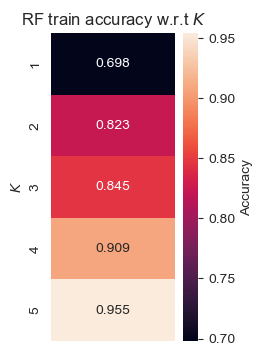

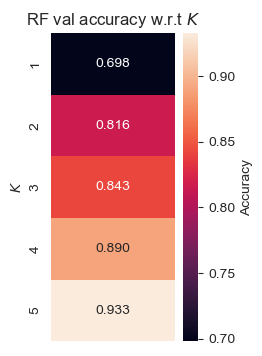

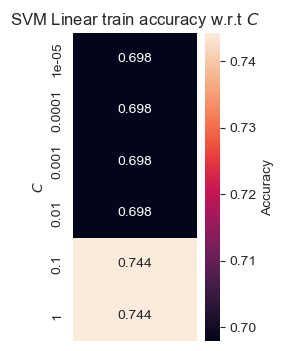

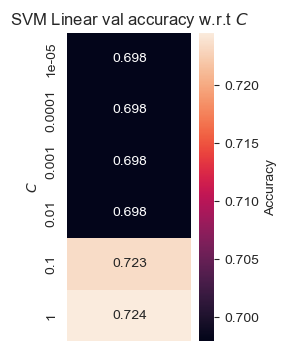

Trial # =  3
Avg Test Accuracy for Decision Tree (DT) =  0.9259259259259259
Avg Test Accuracy for KNN =  0.9158950617283951
Avg Test Accuracy for Random Forest =  0.9313271604938271
Avg Test Accuracy for SVM Linear =  0.7129629629629629
Partition:  0.8
(1382, 6) (346, 6) (1382,) (346,)


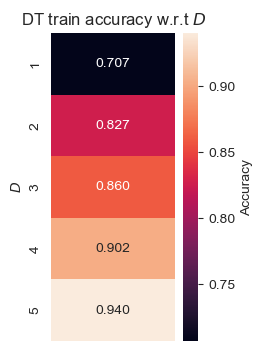

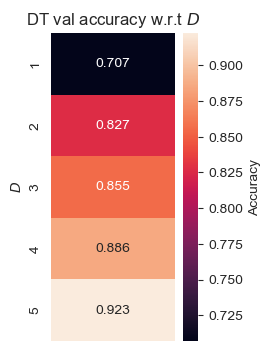

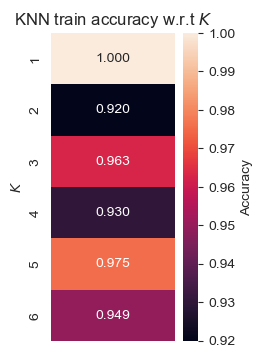

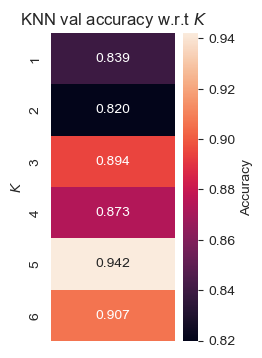

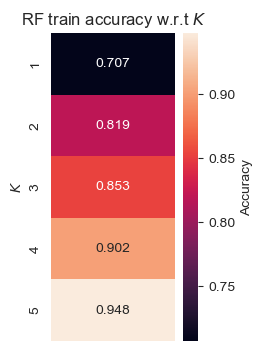

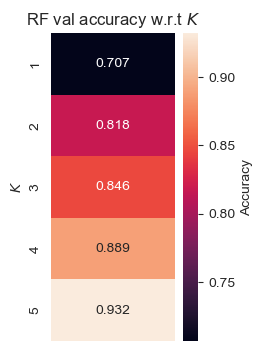

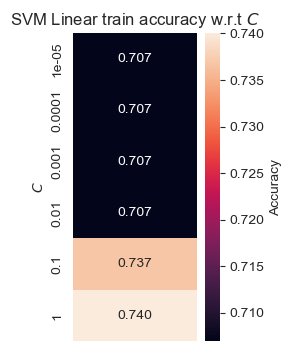

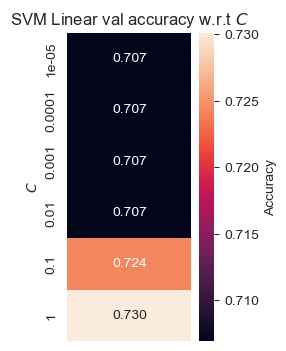

Trial # =  1
(1382, 6) (346, 6) (1382,) (346,)


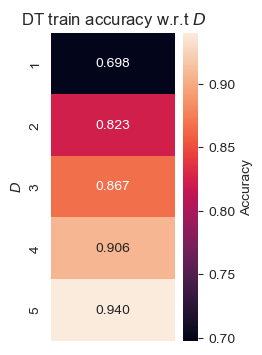

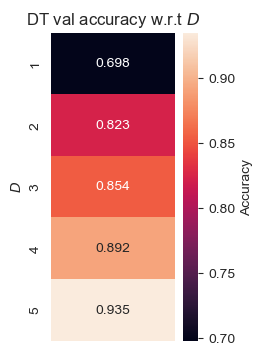

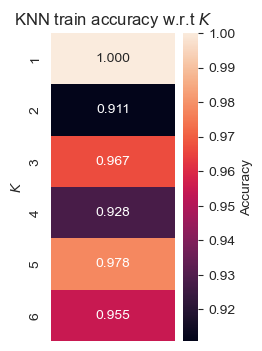

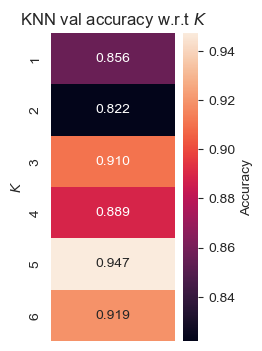

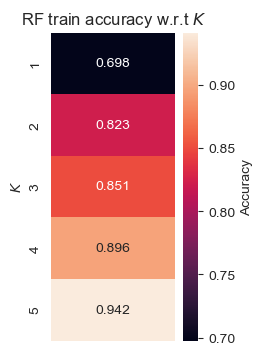

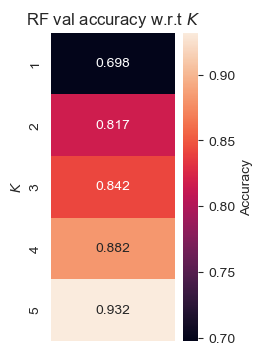

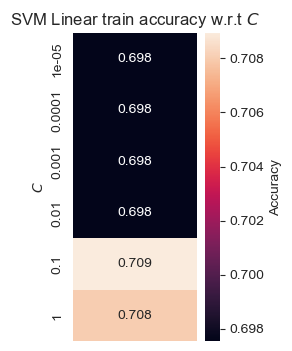

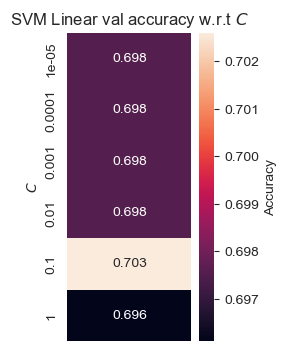

Trial # =  2
(1382, 6) (346, 6) (1382,) (346,)


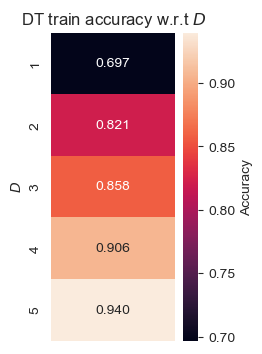

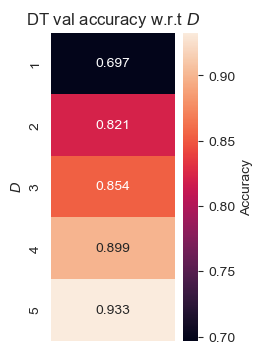

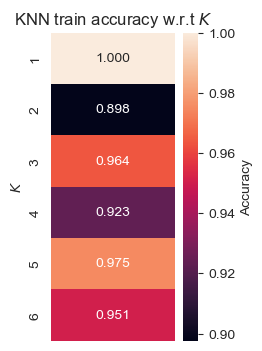

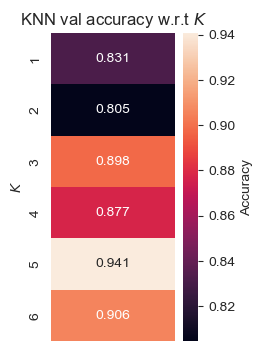

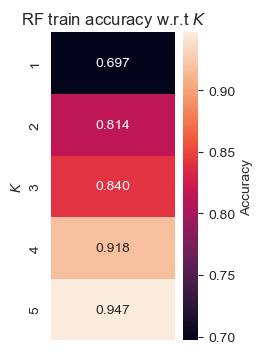

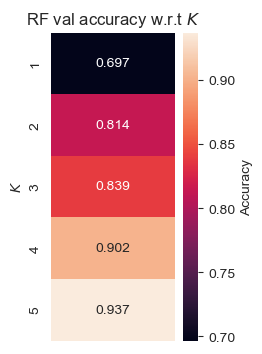

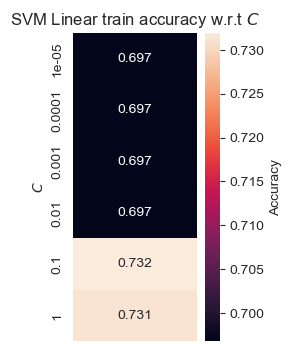

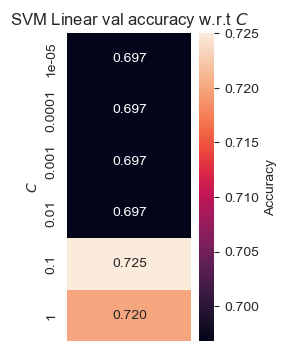

Trial # =  3
Avg Test Accuracy for Decision Tree (DT) =  0.9315992292870905
Avg Test Accuracy for KNN =  0.9421965317919075
Avg Test Accuracy for Random Forest =  0.9364161849710984
Avg Test Accuracy for SVM Linear =  0.7119460500963392


In [34]:
#List partitions: 20/80, 50/50, 80/20
partition_nums = [0.2, 0.5, 0.8]

#Prepare result tables: test accuracy, best training accuracy, best parameter
test_acc_table = np.zeros((3,4))
best_train_table = np.zeros((3,4))
best_param_table = np.zeros((3,4))

#Perform classification over number of trials

for i, partition in enumerate(partition_nums):
    print("Partition: ", partition)
    
    #Prepare arrays to hold the test accuracies from each classifier
    DT_test_acc = []
    KNN_test_acc = []
    RF_test_acc = []
    SVM_test_acc = []
    
    #3 trials per partition
    num_trials = 3
    
    #Begin conducting trials and performing classification
    for trial in range(num_trials):
        #Shuffle the data to ensure randomization
        np.random.shuffle(data)
        
        #Find the partition point
        breakNum = int(partition * len(data))
        
        #Make the training and testing sets
        X_train_val = data[:breakNum,:-1]
        Y_train_val = data[:breakNum,-1]
        X_test = data[breakNum:,:-1]
        Y_test = data[breakNum:,-1]
        
        print(X_train_val.shape, X_test.shape, Y_train_val.shape, Y_test.shape)
        
        #Now we call the classifier functions defined in Step 2
        #After each function call, append the test accuracy to the appropriate array
        
        #Decision Tree Classifier
        test_acc, DT_best_train, DT_best_param = decision_tree(X_train_val, Y_train_val, X_test, Y_test)
        DT_test_acc.append(test_acc)
        
        #KNN Classifier
        test_acc, KNN_best_train, KNN_best_param = knn_classifier(X_train_val, Y_train_val, X_test, Y_test)
        KNN_test_acc.append(test_acc)
        
        #Random Forest Classifier
        test_acc, RF_best_train, RF_best_param = random_forest(X_train_val, Y_train_val, X_test, Y_test)
        RF_test_acc.append(test_acc)
        
        #SVM linear Classifier
        test_acc, SVM_best_train, SVM_best_param = svm_linear(X_train_val, Y_train_val, X_test, Y_test)
        SVM_test_acc.append(test_acc)
        
        print("Trial # = ", trial + 1)

    #Calculate the average test accuracies across the trials for each classifier
    DT_avg_test_acc = sum(DT_test_acc)/num_trials
    KNN_avg_test_acc = sum(KNN_test_acc)/num_trials
    RF_avg_test_acc = sum(RF_test_acc)/num_trials
    SVM_avg_test_acc = sum(SVM_test_acc)/num_trials
    
    #Fill in test_acc table with average test accuracy for each classifier
    test_acc_table[i,0] = DT_avg_test_acc
    test_acc_table[i,1] = KNN_avg_test_acc
    test_acc_table[i,2] = RF_avg_test_acc
    test_acc_table[i,3] = SVM_avg_test_acc
    
    #Fill in best_train table with best training accuracy for each classifier
    best_train_table[i,0] = DT_best_train
    best_train_table[i,1] = KNN_best_train
    best_train_table[i,2] = RF_best_train
    best_train_table[i,3] = SVM_best_train
    
    #Fill in best_param table with best hyperparameter for each classifier
    best_param_table[i,0] = DT_best_param
    best_param_table[i,1] = KNN_best_param
    best_param_table[i,2] = RF_best_param
    best_param_table[i,3] = SVM_best_param
    
    #Print out average test accuracies for the trials for each classifier
    print("Avg Test Accuracy for Decision Tree (DT) = ", DT_avg_test_acc)
    print("Avg Test Accuracy for KNN = ", KNN_avg_test_acc)
    print("Avg Test Accuracy for Random Forest = ", RF_avg_test_acc)
    print("Avg Test Accuracy for SVM Linear = ", SVM_avg_test_acc)

In [35]:
#Print out tables
print("Y-axis: partitions = 20/80, 50/50, 80/20")
print("X-axis: classifiers = Decision Tree, KNN, Random Forest, SVM Linear")
print("-----------------------------------------------------------------------")
print("Test Accuracy Table")
print(test_acc_table)
print("-----------------------------------------------------------------------")
print("Best Training Accuracy Table")
print(best_train_table)
print("-----------------------------------------------------------------------")
print("Best Parameter Table")
print(best_param_table)

Y-axis: partitions = 20/80, 50/50, 80/20
X-axis: classifiers = Decision Tree, KNN, Random Forest, SVM Linear
-----------------------------------------------------------------------
Test Accuracy Table
[[0.93612919 0.84357677 0.91805254 0.703302  ]
 [0.92592593 0.91589506 0.93132716 0.71296296]
 [0.93159923 0.94219653 0.93641618 0.71194605]]
-----------------------------------------------------------------------
Best Training Accuracy Table
[[0.93913043 0.92246377 0.96304348 0.70869565]
 [0.93749864 0.96035694 0.95456907 0.74421003]
 [0.93994125 0.97485505 0.94681482 0.73190757]]
-----------------------------------------------------------------------
Best Parameter Table
[[5.  3.  5.  0.1]
 [5.  5.  5.  1. ]
 [5.  5.  5.  0.1]]
